# 解压训练/测试样本和标签文件

In [1]:
import os
import gzip

mnist_dir = "./data" # 下载的MNIST的文件夹路径
X_train_fpath = os.path.join(mnist_dir, "train-images-idx3-ubyte.gz")
Y_train_fpath = os.path.join(mnist_dir, "train-labels-idx1-ubyte.gz")
X_test_fpath = os.path.join(mnist_dir, "t10k-images-idx3-ubyte.gz")
Y_test_fpath = os.path.join(mnist_dir, "t10k-labels-idx1-ubyte.gz")
with gzip.open(X_train_fpath, 'rb') as f:
    X_train_content = f.read()
with gzip.open(Y_train_fpath, 'rb') as f:
    Y_train_content = f.read()
with gzip.open(X_test_fpath, 'rb') as f:
    X_test_content = f.read()
with gzip.open(Y_test_fpath, 'rb') as f:
    Y_test_content = f.read()

# 获取训练样本和标签文件信息

In [2]:
X_train_bytes = len(X_train_content) # 解压后的训练图集文件大小
X_train_magic_number = X_train_content[:4].hex() # magic number 0x00000803(2051)
X_train_images = int(X_train_content[4:8].hex(), 16) # 图像数量 60,000
Y_train_bytes = len(Y_train_content) # 解压后训练标签文件大小
Y_train_magic_number = Y_train_content[:4].hex() # magic number 0x00000801(2049)
Y_train_labels = int(Y_train_content[4:8].hex(), 16) # 标签数量 60,000，标签范围 [0,9]

num_rows = int(X_train_content[8:12].hex(), 16) # 图像高 28
num_cols = int(X_train_content[12:16].hex(),16) # 图像宽 28
num_pixels = num_rows * num_cols # 图像大小 784

print(X_train_bytes, Y_train_bytes)
print(X_train_magic_number, int(X_train_magic_number,16), Y_train_magic_number, int(Y_train_magic_number,16))
print(X_train_images, Y_train_labels)
print(num_rows)
print(num_cols)
print(num_pixels)

47040016 60008
00000803 2051 00000801 2049
60000 60000
28
28
784


# 查看训练样本和标签

[35836, 4907, 1394, 21883, 10260, 13128, 27032, 8038]


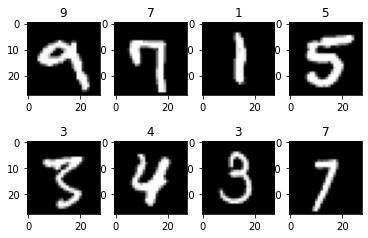

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

X_train = []
Y_train = []

for i in range(16, X_train_bytes, num_pixels):
    # 读取784个字节并转换为numpy数组形式，再reshape为28*28
    ndata = np.frombuffer(X_train_content[i:i+num_pixels], dtype=np.uint8).reshape(28,28,1)
    X_train.append(ndata)
    
for i in range(8, Y_train_bytes):
    Y_train.append(Y_train_content[i])

X_train = np.array(X_train)
Y_train = np.array(Y_train, dtype=np.int64)

# 随机挑选8个看一下
choices = random.sample(range(X_train_images), 8)
labels = Y_train[choices]
print(choices)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[choices[i]], cmap='gray')
    plt.title("{i}".format(i=labels[i]))
plt.show()

# 将训练集划分为训练集和验集

In [4]:
# !conda install scikit-learn # 报错，找不到sklearn模块时取消注释
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=123)
print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)

(42000, 28, 28, 1) (18000, 28, 28, 1)
(42000,) (18000,)


# 定义网络

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        x = nn.Dropout(0.25)(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.5)(x)
        x = F.relu(self.fc2(x))
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 定义数据集
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        Y = self.Y[idx]
        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            Y = self.target_transform(Y)
        return X, Y

transform = transforms.ToTensor()

datasets = {
    'train': MyDataset(X_train, Y_train, transform),
    'val': MyDataset(X_val, Y_val, transform)
}

dataset_sizes = {
    'train': len(datasets['train']),
    'val': len(datasets['val'])
}

batch_size = 128

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(datasets['val'], batch_size=batch_size, shuffle=False)
}

# 训练
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [7]:
import time
import copy
from torch.optim import Adam, lr_scheduler

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 10

since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    print()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 0/9
----------
train Loss: 0.3753 Acc: 0.8850
val Loss: 0.1623 Acc: 0.9538

Epoch 1/9
----------
train Loss: 0.1269 Acc: 0.9625
val Loss: 0.1113 Acc: 0.9677

Epoch 2/9
----------
train Loss: 0.0931 Acc: 0.9720
val Loss: 0.0959 Acc: 0.9723

Epoch 3/9
----------
train Loss: 0.0738 Acc: 0.9775
val Loss: 0.0927 Acc: 0.9734

Epoch 4/9
----------
train Loss: 0.0637 Acc: 0.9815
val Loss: 0.0772 Acc: 0.9782

Epoch 5/9
----------
train Loss: 0.0573 Acc: 0.9827
val Loss: 0.0752 Acc: 0.9778

Epoch 6/9
----------
train Loss: 0.0502 Acc: 0.9846
val Loss: 0.0767 Acc: 0.9777

Epoch 7/9
----------
train Loss: 0.0439 Acc: 0.9861
val Loss: 0.0747 Acc: 0.9795

Epoch 8/9
----------
train Loss: 0.0426 Acc: 0.9862
val Loss: 0.0737 Acc: 0.9796

Epoch 9/9
----------
train Loss: 0.0375 Acc: 0.9883
val Loss: 0.0735 Acc: 0.9799

Training complete in 0m 45s
Best val Acc: 0.979889


# 测试

In [44]:
X_test_bytes = len(X_test_content)
Y_test_bytes = len(Y_test_content)

X_test = []
Y_test = []

for i in range(16, X_test_bytes, num_pixels):
    ndata = np.frombuffer(X_test_content[i:i+num_pixels], dtype=np.uint8).reshape(28,28,1)
    X_test.append(ndata)
    
for i in range(8, Y_test_bytes):
    Y_test.append(Y_test_content[i])

X_test = np.array(X_test)
Y_test = np.array(Y_test, dtype=np.int64)

testset = MyDataset(X_test, Y_test, transform)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
total = len(testset)
corrects = 0

# 读取最佳权重
model.load_state_dict(best_model_wts)
model.eval()

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
print("Test Acc: {:.4f}".format(corrects.double() / total))

Test Acc: 0.9830


# 保存模型

In [45]:
path = "mnist.pt"
torch.save(best_model_wts, path)